<a href="https://colab.research.google.com/github/vackup/CovidArgentina/blob/master/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import generales

In [0]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from google.colab import drive
import urllib.request
import json
import os

In [60]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Global settings and functions

In [0]:
today = date.today()
days_name_weekends = ['Saturday','Sunday']
base_path = '/content/drive/My Drive/Colab Notebooks/'
path_google_dataset = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'

In [0]:
def get_df_without_weekends_and_holidays(df):
    df_without_weekends_and_holidays = df[~df.index.isin(df_feriados.index)]
    df_without_weekends_and_holidays = df_without_weekends_and_holidays[~df_without_weekends_and_holidays['Weekday Name'].isin(days_name_weekends)]

    return df_without_weekends_and_holidays

def get_df_only_weekends_and_holidays(df):
    df_only_holidays = df[df.index.isin(df_feriados.index)]
    df_only_weekends = df[df['Weekday Name'].isin(days_name_weekends)]

    df_contat = pd.concat([df_only_weekends, df_only_holidays])

    df_contat = df_contat.sort_index()

    return df_contat

def get_df_only_weekends(df):
    df_only_weekends = df[df['Weekday Name'].isin(days_name_weekends)]

    return df_only_weekends

# note: Apple can unexpectedly change version
def download_apple_report(directory="apple_reports"):
    '''Download Apple Mobility Trends report in CSV

        Args:
            directory: directory to which CSV report will be downloaded

        Returns:
            new_files (bool): flag indicating whether or not a new file has been downloaded
    '''
    version = "v3"
    json_link = "https://covid19-static.cdn-apple.com/covid19-mobility-data/current/" + version + "/index.json"
    with urllib.request.urlopen(json_link) as url:
           json_data = json.loads(url.read().decode())
    
    full_path = json_data['regions']['en-us']['csvPath']
    
    link = "https://covid19-static.cdn-apple.com" + json_data['basePath'] + full_path
    new_files = False

    if not os.path.exists(directory):
        os.makedirs(directory)
    
    #file_name = "applemobilitytrends.csv"
    file_name = full_path.split('/')[-1] # last element

    if link[-3:] == "csv":
        path = os.path.join(directory, file_name)
        if not os.path.isfile(path):
            new_files = True
            urllib.request.urlretrieve(link, path)
            print(file_name)
        else:
            path_new = os.path.join(directory, file_name + "_new")
            urllib.request.urlretrieve(link, path_new)
            if os.path.getsize(path) == os.path.getsize(path_new):
                os.remove(path_new)
            else:
                new_files = True
                os.remove(path)
                os.rename(path_new, path)

    if not new_files:
        print('Apple: No updates')

    return new_files, file_name

# Dataset evolucion diaria infectados, muertos y recuperados

In [0]:
df = pd.read_json('https://pomber.github.io/covid19/timeseries.json')

In [0]:
df2 = pd.DataFrame(df['Argentina'].values.tolist())


In [0]:
df2['date'] = pd.to_datetime(df2['date'])
df2 = df2.set_index('date')
df2 = df2.loc['2020-03-01' : today]

In [66]:
df2.shape


(80, 3)

In [67]:
df2.head(3)

,confirmed,deaths,recovered
date,,,
2020-03-01,0,0,0
2020-03-02,0,0,0
2020-03-03,1,0,0


In [68]:
df2.tail(3)

,confirmed,deaths,recovered
date,,,
2020-05-17,8068,373,2569
2020-05-18,8371,382,2625
2020-05-19,8809,393,2872


In [69]:
df2.dtypes

confirmed    int64
deaths       int64
recovered    int64
dtype: object

In [70]:
df2.index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25',
      

In [0]:
df2['Weekday Name'] = df2.index.day_name()

In [72]:
# Display a random sampling of 5 rows
df2.sample(5, random_state=0)

,confirmed,deaths,recovered,Weekday Name
date,,,,
2020-04-20,2941,136,737,Monday
2020-03-28,690,18,72,Saturday
2020-03-31,1054,27,240,Tuesday
2020-05-17,8068,373,2569,Sunday
2020-04-15,2443,111,596,Wednesday


In [0]:
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(25, 15)})

In [0]:
#cols_plot = ['confirmed', 'deaths', 'recovered']

#axes = df2[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
#for ax in axes:
#    ax.set_ylabel('Daily Totals')

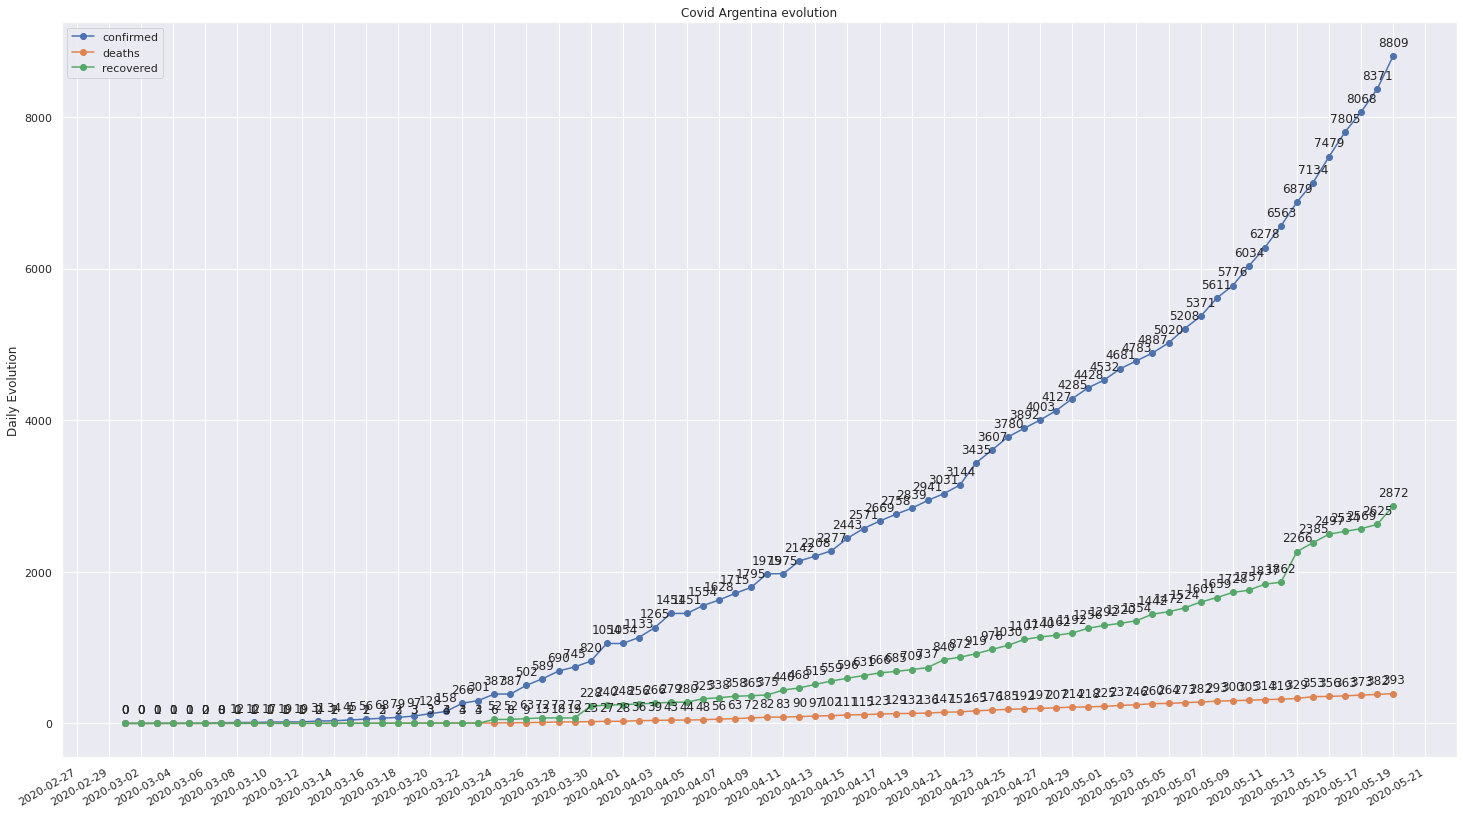

In [75]:
cols_plot = ['confirmed', 'deaths', 'recovered']

fig, ax = plt.subplots()

ax.plot(df2['confirmed'], marker='o', linestyle='-', label='confirmed')
ax.plot(df2['deaths'], marker='o', linestyle='-', label='deaths')
ax.plot(df2['recovered'], marker='o', linestyle='-', label='recovered')
#ax.plot(df2[cols_plot], marker='o', linestyle='-')

ax.set_ylabel('Daily Evolution')
ax.set_title('Covid Argentina evolution')

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

plt.legend(loc="upper left")
#plt.legend(cols_plot)

fig.autofmt_xdate()

for X, Y in zip(df2.index, df2['confirmed']):
    label = "{:.0f}".format(Y)

    ax.annotate(label, # this is the text
                 (X,Y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for X, Y in zip(df2.index, df2['deaths']):
    label = "{:.0f}".format(Y)

    ax.annotate(label, # this is the text
                 (X,Y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for X, Y in zip(df2.index, df2['recovered']):
    label = "{:.0f}".format(Y)

    ax.annotate(label, # this is the text
                 (X,Y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# Dataset feriados

In [0]:
path_feriados = base_path + 'feriados2020.csv'
df_feriados = pd.read_csv(path_feriados)

In [77]:
df_feriados.head()

,Fecha
0,2020-1-1
1,2020-2-24
2,2020-2-25
3,2020-3-23
4,2020-3-24


In [0]:
df_feriados.Fecha = pd.to_datetime(df_feriados.Fecha)

In [79]:
df_feriados.dtypes

Fecha    datetime64[ns]
dtype: object

In [0]:
df_feriados = df_feriados.set_index('Fecha')

In [81]:
df_feriados.index

DatetimeIndex(['2020-01-01', '2020-02-24', '2020-02-25', '2020-03-23',
               '2020-03-24', '2020-03-31', '2020-04-09', '2020-04-10',
               '2020-05-01', '2020-05-25', '2020-06-15', '2020-06-20',
               '2020-07-09', '2020-07-10', '2020-08-17', '2020-10-12',
               '2020-11-23', '2020-12-07', '2020-12-08', '2020-12-24',
               '2020-12-25', '2020-12-31'],
              dtype='datetime64[ns]', name='Fecha', freq=None)

# Dataset Apple mobility

In [82]:
new_files, apple_dataset_file_name = download_apple_report(base_path)

print(new_files, apple_dataset_file_name)

Apple: No updates
False applemobilitytrends-2020-05-18.csv


In [0]:
path_apple_dataset = base_path + apple_dataset_file_name
df_apple = pd.read_csv(path_apple_dataset)

In [84]:
df_apple.head(5)

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,...,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18
0,country/region,Albania,driving,NaN,NaN,NaN,100.0,95.30,101.43,97.20,103.55,112.67,104.83,94.39,94.07,93.51,92.94,102.13,102.38,101.41,94.62,89.12,90.17,90.21,97.71,102.50,108.92,92.82,91.48,93.99,96.72,102.46,103.29,107.83,87.99,94.18,94.62,99.70,139.30,123.90,...,26.70,26.32,25.47,24.89,32.64,31.43,30.67,30.00,29.26,22.94,24.55,31.51,33.59,31.69,33.94,30.22,25.22,30.39,37.39,36.69,35.90,38.09,37.23,29.36,36.00,43.69,42.61,43.11,46.13,45.78,41.59,45.39,NaN,NaN,49.19,50.20,48.30,46.78,45.51,56.09
1,country/region,Albania,walking,NaN,NaN,NaN,100.0,100.68,98.93,98.46,100.85,100.13,82.13,95.65,97.78,95.39,94.24,93.73,97.06,77.27,83.37,82.73,84.39,88.19,90.79,88.70,79.32,87.12,88.06,99.40,85.84,94.63,99.74,81.41,90.19,90.45,94.16,95.69,109.21,108.40,...,28.96,27.29,27.63,29.59,35.52,38.08,35.48,39.15,34.58,27.76,27.93,36.72,34.46,35.39,34.80,34.63,29.00,35.22,41.83,37.53,41.49,38.25,38.68,32.28,43.41,49.59,46.44,52.84,52.37,48.10,44.86,68.87,NaN,NaN,61.79,56.46,54.41,48.36,45.20,67.46
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,118.45,124.01,95.44,95.13,95.42,97.66,99.42,113.34,118.23,91.31,93.37,91.12,92.35,96.74,111.24,123.96,89.01,91.66,89.18,94.49,95.98,111.12,121.53,89.23,96.42,96.97,101.68,104.90,122.91,127.62,...,19.80,16.80,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67,27.25,27.61,28.73,30.99,25.92,16.57,27.45,27.12,32.22,34.45,22.69,28.23,16.44,32.01,33.63,35.13,35.56,40.25,33.82,19.82,NaN,NaN,38.87,41.01,44.34,38.29,22.01,40.01
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,116.72,114.14,84.54,101.37,106.12,104.91,102.56,104.88,98.83,73.64,94.27,93.86,92.20,96.00,98.99,97.42,67.21,95.18,96.25,100.39,99.10,105.00,106.45,73.12,104.20,105.87,111.47,113.20,128.75,103.47,...,14.65,13.58,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44,19.01,18.47,20.39,22.32,23.31,16.36,18.48,17.49,22.78,24.80,16.62,20.61,12.44,21.35,22.63,23.84,23.84,30.63,24.84,15.58,NaN,NaN,28.33,28.44,31.63,28.81,18.49,30.79
4,country/region,Australia,driving,AU,NaN,NaN,100.0,102.98,104.21,108.63,109.08,89.00,99.35,103.53,106.80,107.40,115.65,109.66,88.59,85.18,95.91,99.40,99.92,103.04,103.73,85.73,93.39,95.83,98.63,102.40,107.46,106.55,86.33,98.78,100.08,103.28,106.19,116.62,115.36,93.51,...,33.19,36.00,26.95,31.72,53.14,55.91,56.56,58.77,47.51,36.90,53.34,56.93,58.06,59.69,62.87,47.84,41.89,55.39,59.09,59.46,59.46,63.12,58.40,48.67,58.18,62.51,64.04,66.19,71.34,67.64,50.96,63.56,NaN,NaN,71.12,77.24,79.75,65.88,72.17,73.58


In [0]:
df_apple_argentina = df_apple[df_apple.region.eq("Argentina")]

In [86]:
df_apple_argentina.head()

,geo_type,region,transportation_type,alternative_name,sub-region,country,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,...,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18
2,country/region,Argentina,driving,NaN,NaN,NaN,100.0,97.07,102.45,111.21,118.45,124.01,95.44,95.13,95.42,97.66,99.42,113.34,118.23,91.31,93.37,91.12,92.35,96.74,111.24,123.96,89.01,91.66,89.18,94.49,95.98,111.12,121.53,89.23,96.42,96.97,101.68,104.9,122.91,127.62,...,19.80,16.80,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67,27.25,27.61,28.73,30.99,25.92,16.57,27.45,27.12,32.22,34.45,22.69,28.23,16.44,32.01,33.63,35.13,35.56,40.25,33.82,19.82,NaN,NaN,38.87,41.01,44.34,38.29,22.01,40.01
3,country/region,Argentina,walking,NaN,NaN,NaN,100.0,95.11,101.37,112.67,116.72,114.14,84.54,101.37,106.12,104.91,102.56,104.88,98.83,73.64,94.27,93.86,92.20,96.00,98.99,97.42,67.21,95.18,96.25,100.39,99.10,105.00,106.45,73.12,104.20,105.87,111.47,113.2,128.75,103.47,...,14.65,13.58,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44,19.01,18.47,20.39,22.32,23.31,16.36,18.48,17.49,22.78,24.80,16.62,20.61,12.44,21.35,22.63,23.84,23.84,30.63,24.84,15.58,NaN,NaN,28.33,28.44,31.63,28.81,18.49,30.79


In [87]:
df_apple_argentina.drop(columns=['geo_type', 'region', 'alternative_name', 'sub-region', 'country'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [88]:
df_apple_argentina.head()

,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,2020-01-21,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,2020-02-01,2020-02-02,2020-02-03,2020-02-04,2020-02-05,2020-02-06,2020-02-07,2020-02-08,2020-02-09,2020-02-10,2020-02-11,2020-02-12,2020-02-13,2020-02-14,2020-02-15,2020-02-16,2020-02-17,2020-02-18,2020-02-19,2020-02-20,...,2020-04-09,2020-04-10,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,2020-05-01,2020-05-02,2020-05-03,2020-05-04,2020-05-05,2020-05-06,2020-05-07,2020-05-08,2020-05-09,2020-05-10,2020-05-11,2020-05-12,2020-05-13,2020-05-14,2020-05-15,2020-05-16,2020-05-17,2020-05-18
2,driving,100.0,97.07,102.45,111.21,118.45,124.01,95.44,95.13,95.42,97.66,99.42,113.34,118.23,91.31,93.37,91.12,92.35,96.74,111.24,123.96,89.01,91.66,89.18,94.49,95.98,111.12,121.53,89.23,96.42,96.97,101.68,104.9,122.91,127.62,88.20,92.28,98.15,98.96,104.71,...,19.80,16.80,19.40,12.89,21.10,22.29,23.55,24.40,27.17,23.19,14.54,26.67,27.25,27.61,28.73,30.99,25.92,16.57,27.45,27.12,32.22,34.45,22.69,28.23,16.44,32.01,33.63,35.13,35.56,40.25,33.82,19.82,NaN,NaN,38.87,41.01,44.34,38.29,22.01,40.01
3,walking,100.0,95.11,101.37,112.67,116.72,114.14,84.54,101.37,106.12,104.91,102.56,104.88,98.83,73.64,94.27,93.86,92.20,96.00,98.99,97.42,67.21,95.18,96.25,100.39,99.10,105.00,106.45,73.12,104.20,105.87,111.47,113.2,128.75,103.47,69.12,93.42,111.49,107.02,111.36,...,14.65,13.58,15.75,10.45,16.35,16.66,17.42,18.18,18.80,17.03,10.59,18.44,19.01,18.47,20.39,22.32,23.31,16.36,18.48,17.49,22.78,24.80,16.62,20.61,12.44,21.35,22.63,23.84,23.84,30.63,24.84,15.58,NaN,NaN,28.33,28.44,31.63,28.81,18.49,30.79


In [0]:
df_apple_argentina = df_apple_argentina.set_index('transportation_type')

In [0]:
df_apple_argentina_t = df_apple_argentina.transpose()

In [91]:
df_apple_argentina_t

transportation_type,driving,walking
2020-01-13,100.00,100.00
2020-01-14,97.07,95.11
2020-01-15,102.45,101.37
2020-01-16,111.21,112.67
2020-01-17,118.45,116.72
...,...,...
2020-05-14,41.01,28.44
2020-05-15,44.34,31.63
2020-05-16,38.29,28.81
2020-05-17,22.01,18.49


In [0]:
# Converting the index as date
df_apple_argentina_t.index = pd.to_datetime(df_apple_argentina_t.index)

In [93]:
type(df_apple_argentina_t.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [94]:
df_apple_argentina_t.head()

transportation_type,driving,walking
2020-01-13,100.00,100.00
2020-01-14,97.07,95.11
2020-01-15,102.45,101.37
2020-01-16,111.21,112.67
2020-01-17,118.45,116.72


In [0]:
df_apple_argentina_t.index.rename('date', inplace=True)

In [96]:
df_apple_argentina_t.head()

transportation_type,driving,walking
date,,
2020-01-13,100.00,100.00
2020-01-14,97.07,95.11
2020-01-15,102.45,101.37
2020-01-16,111.21,112.67
2020-01-17,118.45,116.72


In [0]:
df_apple_argentina_t = df_apple_argentina_t.loc['2020-03-01' : today]

In [98]:
df_apple_argentina_t.head(10)

transportation_type,driving,walking
date,,
2020-03-01,81.13,68.50
2020-03-02,86.76,101.01
2020-03-03,88.90,104.39
2020-03-04,92.74,108.23
2020-03-05,97.45,113.92
2020-03-06,118.32,126.70
2020-03-07,122.78,112.81
2020-03-08,80.36,70.94
2020-03-09,89.28,109.38


In [99]:
df_apple_argentina_t['driving-100'] = df_apple_argentina_t['driving'] - 100
df_apple_argentina_t['walking-100'] = df_apple_argentina_t['walking'] - 100

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [100]:
df_apple_argentina_t.head()

transportation_type,driving,walking,driving-100,walking-100
date,,,,
2020-03-01,81.13,68.50,-18.87,-31.50
2020-03-02,86.76,101.01,-13.24,1.01
2020-03-03,88.90,104.39,-11.10,4.39
2020-03-04,92.74,108.23,-7.26,8.23
2020-03-05,97.45,113.92,-2.55,13.92


In [101]:
df_apple_argentina_t['Weekday Name'] = df_apple_argentina_t.index.day_name()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
df_apple_argentina_t.head(10)

transportation_type,driving,walking,driving-100,walking-100,Weekday Name
date,,,,,
2020-03-01,81.13,68.50,-18.87,-31.50,Sunday
2020-03-02,86.76,101.01,-13.24,1.01,Monday
2020-03-03,88.90,104.39,-11.10,4.39,Tuesday
2020-03-04,92.74,108.23,-7.26,8.23,Wednesday
2020-03-05,97.45,113.92,-2.55,13.92,Thursday
2020-03-06,118.32,126.70,18.32,26.70,Friday
2020-03-07,122.78,112.81,22.78,12.81,Saturday
2020-03-08,80.36,70.94,-19.64,-29.06,Sunday
2020-03-09,89.28,109.38,-10.72,9.38,Monday


In [0]:
df_apple_without_weekends_and_holidays = get_df_without_weekends_and_holidays(df_apple_argentina_t)

In [104]:
df_apple_without_weekends_and_holidays.head(10)

transportation_type,driving,walking,driving-100,walking-100,Weekday Name
date,,,,,
2020-03-02,86.76,101.01,-13.24,1.01,Monday
2020-03-03,88.90,104.39,-11.10,4.39,Tuesday
2020-03-04,92.74,108.23,-7.26,8.23,Wednesday
2020-03-05,97.45,113.92,-2.55,13.92,Thursday
2020-03-06,118.32,126.70,18.32,26.70,Friday
2020-03-09,89.28,109.38,-10.72,9.38,Monday
2020-03-10,89.29,109.62,-10.71,9.62,Tuesday
2020-03-11,82.73,83.06,-17.27,-16.94,Wednesday
2020-03-12,86.67,106.85,-13.33,6.85,Thursday


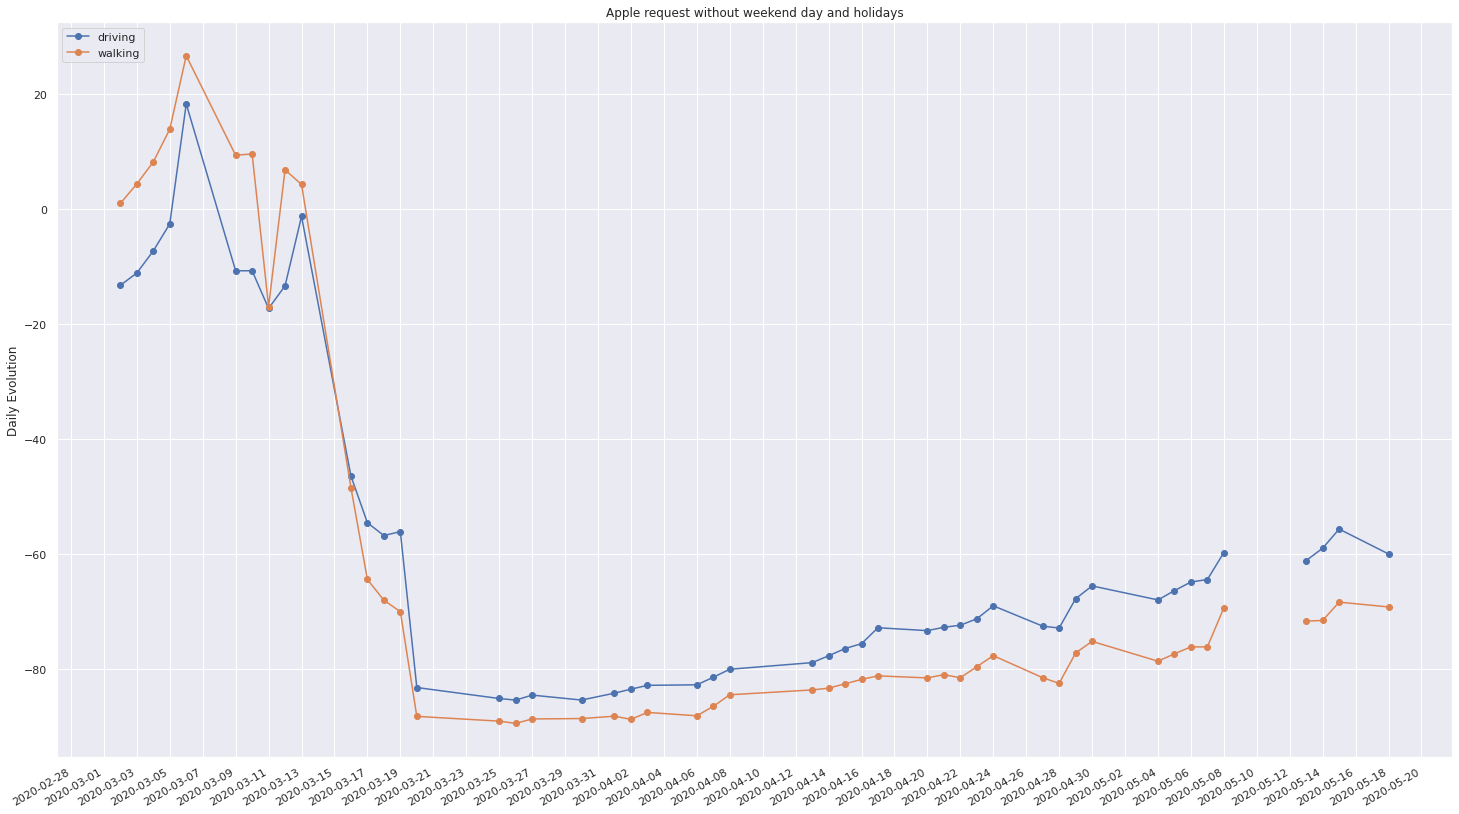

In [105]:
fig, ax = plt.subplots()

ax.plot(df_apple_without_weekends_and_holidays['driving-100'], marker='o', linestyle='-', label='driving')
ax.plot(df_apple_without_weekends_and_holidays['walking-100'], marker='o', linestyle='-', label='walking')

ax.set_ylabel('Daily Evolution')
ax.set_title('Apple request without weekend day and holidays')

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

plt.legend(loc="upper left")

fig.autofmt_xdate()

# Dataset Google Mobility

In [106]:
df_google = pd.read_csv(path_google_dataset)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [107]:
df_google.head(10)

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0
5,AE,United Arab Emirates,NaN,NaN,2020-02-20,-2.0,1.0,6.0,1.0,1.0,1.0
6,AE,United Arab Emirates,NaN,NaN,2020-02-21,-3.0,2.0,6.0,0.0,-1.0,1.0
7,AE,United Arab Emirates,NaN,NaN,2020-02-22,-2.0,2.0,4.0,-2.0,3.0,1.0
8,AE,United Arab Emirates,NaN,NaN,2020-02-23,-1.0,3.0,3.0,-1.0,4.0,1.0
9,AE,United Arab Emirates,NaN,NaN,2020-02-24,-3.0,0.0,5.0,-1.0,3.0,1.0


In [0]:
df_google = df_google[df_google.country_region.eq('Argentina')]

In [109]:
df_google

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
979,AR,Argentina,NaN,NaN,2020-02-15,1.0,-3.0,-3.0,4.0,-1.0,0.0
980,AR,Argentina,NaN,NaN,2020-02-16,-6.0,-6.0,-14.0,-2.0,-4.0,2.0
981,AR,Argentina,NaN,NaN,2020-02-17,-10.0,-8.0,-23.0,-2.0,7.0,1.0
982,AR,Argentina,NaN,NaN,2020-02-18,3.0,3.0,-2.0,9.0,9.0,-1.0
983,AR,Argentina,NaN,NaN,2020-02-19,1.0,0.0,10.0,8.0,11.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...
3199,AR,Argentina,Tucumán,NaN,2020-05-09,-69.0,-12.0,-82.0,-70.0,-19.0,17.0
3200,AR,Argentina,Tucumán,NaN,2020-05-10,-77.0,-19.0,-83.0,-82.0,-18.0,18.0
3201,AR,Argentina,Tucumán,NaN,2020-05-11,-66.0,-15.0,-79.0,-79.0,-25.0,16.0
3202,AR,Argentina,Tucumán,NaN,2020-05-12,-63.0,-10.0,-77.0,-78.0,-25.0,14.0


In [0]:
df_google = df_google[~df_google.sub_region_1.notnull()]

In [111]:
df_google

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
979,AR,Argentina,NaN,NaN,2020-02-15,1.0,-3.0,-3.0,4.0,-1.0,0.0
980,AR,Argentina,NaN,NaN,2020-02-16,-6.0,-6.0,-14.0,-2.0,-4.0,2.0
981,AR,Argentina,NaN,NaN,2020-02-17,-10.0,-8.0,-23.0,-2.0,7.0,1.0
982,AR,Argentina,NaN,NaN,2020-02-18,3.0,3.0,-2.0,9.0,9.0,-1.0
983,AR,Argentina,NaN,NaN,2020-02-19,1.0,0.0,10.0,8.0,11.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...
1063,AR,Argentina,NaN,NaN,2020-05-09,-75.0,-20.0,-91.0,-53.0,-31.0,21.0
1064,AR,Argentina,NaN,NaN,2020-05-10,-82.0,-41.0,-93.0,-65.0,-35.0,21.0
1065,AR,Argentina,NaN,NaN,2020-05-11,-71.0,-24.0,-88.0,-53.0,-36.0,19.0
1066,AR,Argentina,NaN,NaN,2020-05-12,-70.0,-21.0,-88.0,-51.0,-36.0,19.0


In [112]:
df_google.drop(columns=['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2'], inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [113]:
df_google.head()

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
979,2020-02-15,1.0,-3.0,-3.0,4.0,-1.0,0.0
980,2020-02-16,-6.0,-6.0,-14.0,-2.0,-4.0,2.0
981,2020-02-17,-10.0,-8.0,-23.0,-2.0,7.0,1.0
982,2020-02-18,3.0,3.0,-2.0,9.0,9.0,-1.0
983,2020-02-19,1.0,0.0,10.0,8.0,11.0,-2.0


In [114]:
df_google.dtypes

date                                                   object
retail_and_recreation_percent_change_from_baseline    float64
grocery_and_pharmacy_percent_change_from_baseline     float64
parks_percent_change_from_baseline                    float64
transit_stations_percent_change_from_baseline         float64
workplaces_percent_change_from_baseline               float64
residential_percent_change_from_baseline              float64
dtype: object

In [115]:
df_google.date = pd.to_datetime(df_google.date)

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [116]:
df_google.dtypes

date                                                  datetime64[ns]
retail_and_recreation_percent_change_from_baseline           float64
grocery_and_pharmacy_percent_change_from_baseline            float64
parks_percent_change_from_baseline                           float64
transit_stations_percent_change_from_baseline                float64
workplaces_percent_change_from_baseline                      float64
residential_percent_change_from_baseline                     float64
dtype: object

In [0]:
df_google = df_google.set_index('date')

In [118]:
df_google.index

DatetimeIndex(['2020-02-15', '2020-02-16', '2020-02-17', '2020-02-18',
               '2020-02-19', '2020-02-20', '2020-02-21', '2020-02-22',
               '2020-02-23', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28', '2020-02-29', '2020-03-01',
               '2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11', '2020-03-12', '2020-03-13',
               '2020-03-14', '2020-03-15', '2020-03-16', '2020-03-17',
               '2020-03-18', '2020-03-19', '2020-03-20', '2020-03-21',
               '2020-03-22', '2020-03-23', '2020-03-24', '2020-03-25',
               '2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29',
               '2020-03-30', '2020-03-31', '2020-04-01', '2020-04-02',
               '2020-04-03', '2020-04-04', '2020-04-05', '2020-04-06',
               '2020-04-07', '2020-04-08', '2020-04-09', '2020-04-10',
      

In [119]:
df_google = df_google.loc['2020-03-01' : today]
df_google.head(10)

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
date,,,,,,
2020-03-01,-3.0,3.0,-11.0,1.0,-2.0,2.0
2020-03-02,1.0,4.0,-8.0,7.0,16.0,-1.0
2020-03-03,0.0,5.0,-6.0,8.0,16.0,-1.0
2020-03-04,-1.0,3.0,-1.0,8.0,18.0,-2.0
2020-03-05,1.0,4.0,-9.0,10.0,18.0,-1.0
2020-03-06,6.0,8.0,-7.0,12.0,18.0,-2.0
2020-03-07,5.0,7.0,-10.0,8.0,3.0,1.0
2020-03-08,3.0,4.0,-12.0,3.0,-2.0,2.0
2020-03-09,1.0,5.0,-9.0,13.0,15.0,-1.0


In [0]:
df_google['Weekday Name'] = df_google.index.day_name()

In [0]:
df_google_without_weekends_and_holidays = get_df_without_weekends_and_holidays(df_google)

In [122]:
df_google_without_weekends_and_holidays.head(100)

,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Weekday Name
date,,,,,,,
2020-03-02,1.0,4.0,-8.0,7.0,16.0,-1.0,Monday
2020-03-03,0.0,5.0,-6.0,8.0,16.0,-1.0,Tuesday
2020-03-04,-1.0,3.0,-1.0,8.0,18.0,-2.0,Wednesday
2020-03-05,1.0,4.0,-9.0,10.0,18.0,-1.0,Thursday
2020-03-06,6.0,8.0,-7.0,12.0,18.0,-2.0,Friday
2020-03-09,1.0,5.0,-9.0,13.0,15.0,-1.0,Monday
2020-03-10,3.0,8.0,-9.0,14.0,18.0,-2.0,Tuesday
2020-03-11,-16.0,-7.0,-24.0,-6.0,15.0,0.0,Wednesday
2020-03-12,-4.0,8.0,-16.0,10.0,18.0,-1.0,Thursday


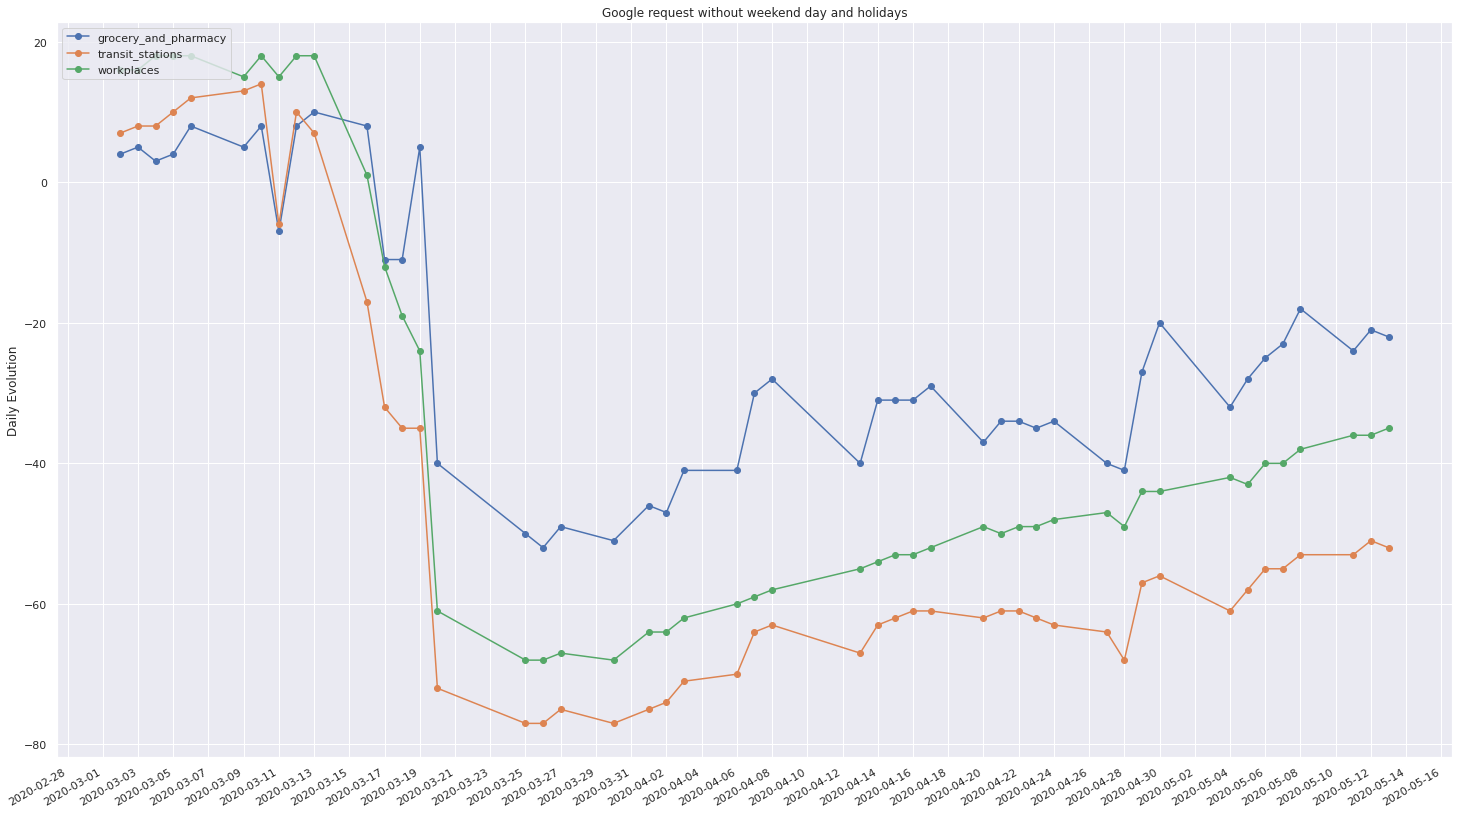

In [123]:
fig, ax = plt.subplots()

ax.plot(df_google_without_weekends_and_holidays['grocery_and_pharmacy_percent_change_from_baseline'], marker='o', linestyle='-', label='grocery_and_pharmacy')
ax.plot(df_google_without_weekends_and_holidays['transit_stations_percent_change_from_baseline'], marker='o', linestyle='-', label='transit_stations')
ax.plot(df_google_without_weekends_and_holidays['workplaces_percent_change_from_baseline'], marker='o', linestyle='-', label='workplaces')

ax.set_ylabel('Daily Evolution')
ax.set_title('Google request without weekend day and holidays')

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

plt.legend(loc="upper left")

fig.autofmt_xdate()

In [0]:
df_only_weekends = get_df_only_weekends(df_google)

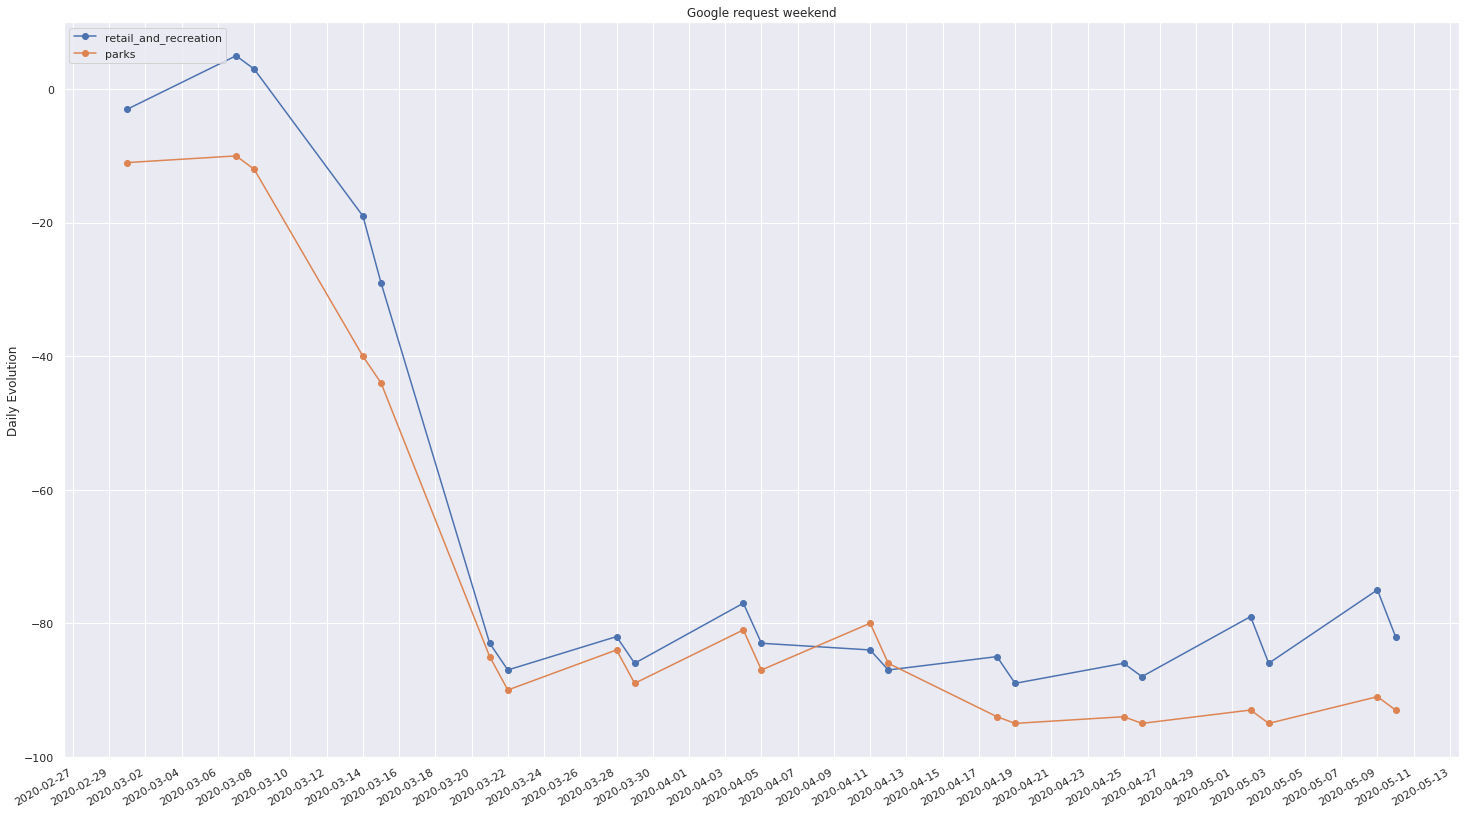

In [125]:
fig, ax = plt.subplots()

ax.plot(df_only_weekends['retail_and_recreation_percent_change_from_baseline'], marker='o', linestyle='-', label='retail_and_recreation')
ax.plot(df_only_weekends['parks_percent_change_from_baseline'], marker='o', linestyle='-', label='parks')
#ax.plot(df_google_only_weekends_and_holidays['residential_percent_change_from_baseline'], marker='o', linestyle='-', label='residential')

ax.set_ylabel('Daily Evolution')
ax.set_title('Google request weekend')

ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'));

plt.legend(loc="upper left")

fig.autofmt_xdate()

# Joins all datasets

In [126]:
df2.index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25',
      

In [127]:
df_google.index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25',
      

In [128]:
df_apple_argentina_t.index

DatetimeIndex(['2020-03-01', '2020-03-02', '2020-03-03', '2020-03-04',
               '2020-03-05', '2020-03-06', '2020-03-07', '2020-03-08',
               '2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14', '2020-03-15', '2020-03-16',
               '2020-03-17', '2020-03-18', '2020-03-19', '2020-03-20',
               '2020-03-21', '2020-03-22', '2020-03-23', '2020-03-24',
               '2020-03-25', '2020-03-26', '2020-03-27', '2020-03-28',
               '2020-03-29', '2020-03-30', '2020-03-31', '2020-04-01',
               '2020-04-02', '2020-04-03', '2020-04-04', '2020-04-05',
               '2020-04-06', '2020-04-07', '2020-04-08', '2020-04-09',
               '2020-04-10', '2020-04-11', '2020-04-12', '2020-04-13',
               '2020-04-14', '2020-04-15', '2020-04-16', '2020-04-17',
               '2020-04-18', '2020-04-19', '2020-04-20', '2020-04-21',
               '2020-04-22', '2020-04-23', '2020-04-24', '2020-04-25',
      

In [0]:
df_all_datasets = pd.concat([df2, df_google, df_apple_argentina_t], axis=1)

In [130]:
df_all_datasets

,confirmed,deaths,recovered,Weekday Name,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,Weekday Name,driving,walking,driving-100,walking-100,Weekday Name
date,,,,,,,,,,,,,,,,
2020-03-01,0,0,0,Sunday,-3.0,3.0,-11.0,1.0,-2.0,2.0,Sunday,81.13,68.50,-18.87,-31.50,Sunday
2020-03-02,0,0,0,Monday,1.0,4.0,-8.0,7.0,16.0,-1.0,Monday,86.76,101.01,-13.24,1.01,Monday
2020-03-03,1,0,0,Tuesday,0.0,5.0,-6.0,8.0,16.0,-1.0,Tuesday,88.90,104.39,-11.10,4.39,Tuesday
2020-03-04,1,0,0,Wednesday,-1.0,3.0,-1.0,8.0,18.0,-2.0,Wednesday,92.74,108.23,-7.26,8.23,Wednesday
2020-03-05,1,0,0,Thursday,1.0,4.0,-9.0,10.0,18.0,-1.0,Thursday,97.45,113.92,-2.55,13.92,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-15,7479,356,2497,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.34,31.63,-55.66,-68.37,Friday
2020-05-16,7805,363,2534,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.29,28.81,-61.71,-71.19,Saturday
2020-05-17,8068,373,2569,Sunday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22.01,18.49,-77.99,-81.51,Sunday


In [0]:
df_all_datasets.to_excel(base_path + 'all_datasets.xlsx')

In [0]:
df_all_datasets.to_csv(base_path + 'all_datasets.csv')